In [1]:
import os
import torch
import sys 
import numpy as np  
import collections
import torch.utils.data as data 
import torch.nn as nn 
import time 
import matplotlib.pyplot as plt
from torch.nn import functional as F 
import math
min_loss = 1e10

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MutiAtten(nn.Module):
    """多头注意力层, 当forward的参数只有x时输入x.shape = (batch_size, len, ndim) out.shape = (batch_size, len, ndim)
    否则，输入k,q,v(batch_size, len, dim) --> out (batch_size, len, ndim)"""
    def __init__(self, ndim, h, drop_v, masked_len=None, is_cross=False):
        super(MutiAtten, self).__init__()
        assert ndim % h == 0 
        # x.shape = (batch_size, len, ndim)
        if not is_cross:
            self.x2kqv = nn.Linear(ndim, 3 * ndim)  # out.shape = (batch_size, len, ndim)
        else:
            self.wq = nn.Linear(ndim, ndim)
            self.wv = nn.Linear(ndim, ndim)
            self.wk = nn.Linear(ndim, ndim)

        self.final_proj = nn.Linear(ndim, ndim)

        self.dropout = nn.Dropout(drop_v)
        # mask matrix(optional) #todo 初始化一个masked_len * masked_len 的掩码矩阵
        if masked_len != None:
            self.register_buffer("mask", torch.tril(torch.ones(masked_len, masked_len)).view(1, 1, masked_len, masked_len))

        self.h = h 
        self.ndim = ndim 
        self.masked_len = masked_len
        self.atten = None

    def forward(self, x, preinput):
        batch_size, len, ndim = preinput.size() 
        # self attention:
        if x == None:
            k, q, v = self.x2kqv(preinput).split(self.ndim, dim=2) # shape = (batch_size, len, ndim)

            # shape --> (batch_size, h, len, ndim // h)
            for c in (k, q, v):
                c = c.view(batch_size, len, self.h, -1).transpose(1, 2)
            atten_weight = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1)**(0.5)))
            if self.masked_len != None:
                atten_weight = atten_weight.masked_fill(self.mask[:,:,:len,:len] == 0, float('-inf'))
            atten_weight = F.softmax(atten_weight, dim=-1)
            atten_weight = self.dropout(atten_weight) # shape = (batch_size, h, len, len)

            out = atten_weight @ v # shape = (batch_size, h, len, ndim // h)
            self.attenn = atten_weight
            # concat:
            out = out.transpose(1, 2).contiguous().view(batch_size, len, ndim)

            # project:
            out = self.final_proj(out)
            return out  
        # todo cross attention:
        else:
            
            q = self.wq(preinput).view(batch_size, -1, self.h, ndim // self.h).transpose(1, 2)
            k = self.wk(x).view(batch_size, -1, self.h, ndim // self.h).transpose(1, 2)
            v = self.wv(x).view(batch_size, -1, self.h, ndim // self.h).transpose(1, 2)
            # shape = (batch_size, h, len, ndim // h)
            atten_weight = (q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1)))) # (batch_size, h, lenq, lenk)
            if self.masked_len != None:
                atten_weight = atten_weight.masked_fill(self.mask[:,:,:len,:len] == 0, float('-inf'))
            atten_weight = F.softmax(atten_weight, dim=-1)
            atten_weight = self.dropout(atten_weight)
            out = atten_weight @ v 
            self.atten = atten_weight 
            out = out.transpose(1, 2).contiguous().view(batch_size, len, ndim)
            out = self.final_proj(out)
            return out 
                    

class fdfwd(nn.Module):
    """feedforward层"""
    def __init__(self, ndim, ndim_hidden, drop_v=0.1):
        super(fdfwd, self).__init__()
        self.w1 = nn.Linear(ndim, ndim_hidden)
        self.w2 = nn.Linear(ndim_hidden, ndim)
        self.dropout = nn.Dropout(drop_v)
    
    def forward(self, x):
        out = self.w1(x).relu()
        out = self.dropout(out)
        out = self.w2(out)

        return out  
class wordEmbedding(nn.Module):
    """修改后的embedding层，就是将向量乘以sqrt(ndim)"""
    def __init__(self, ndim, vocab):
        super(wordEmbedding, self).__init__()
        self.embd = nn.Embedding(vocab, ndim)
        self.ndim = ndim 

    def forward(self, x):
        return self.embd(x) * math.sqrt(self.ndim)

class postionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, ndim, drop_v, maxlen=5000):
        super(postionalEncoding, self).__init__()
        PE = torch.zeros(maxlen, ndim)
        pos = torch.arange(0, maxlen).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, ndim, 2) * -(math.log(10000.0) / ndim)) 
        PE[:, 0::2] = torch.sin(pos * div_term)
        PE[:, 1::2] = torch.cos(pos * div_term)
        PE = PE.unsqueeze(0)
        self.register_buffer("PE", PE)
        self.dropout = nn.Dropout(drop_v)
    
    def forward(self, x):
        return self.dropout(x + self.PE[:,:x.size(1)].requires_grad_(False))

class LayerNorm(nn.Module):
    def __init__(self, ndim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(ndim))
        self.eps = eps
        self.b = nn.Parameter(torch.zeros(ndim))

    def forward(self, x):
        return self.a * (x - x.mean(-1, keepdim=True)) / (x.std(-1, keepdim=True) + self.eps) + self.b

class encoder(nn.Module):
    """一个编码器块儿"""
    def __init__(self, drop_v, ndim, h, ndim_hidden):
        super(encoder, self).__init__()
        self.attn = MutiAtten(ndim, h, drop_v)
        self.feedforward = fdfwd(ndim, ndim_hidden, drop_v)

        # self.layernorm0 = LayerNorm(ndim)
        self.layernorm1 = LayerNorm(ndim)
        self.layernorm2 = LayerNorm(ndim)
        self.dropout = nn.Dropout(drop_v)
    
    def forward(self, x):
        # x = self.layernorm0(x) #! 为了de一个bug，加上一个层归一化
        x = x + self.dropout(self.attn(None, x))
        x = self.layernorm1(x)
        x = x + self.dropout(self.feedforward(x))
        x = self.layernorm2(x)
        return x 

class decoder(nn.Module):
    """一个解码器块"""
    def __init__(self, ndim, h, drop_v, masked_len, ndim_hidden):
        super(decoder, self).__init__()
        self.selfattn = MutiAtten(ndim, h, drop_v, masked_len)
        self.crossattn = MutiAtten(ndim, h, drop_v, None, True)
        self.feedforward = fdfwd(ndim, ndim_hidden, drop_v)
        self.dropout =nn.Dropout()
        
        # self.layernorm0 = LayerNorm(ndim) #!debug
        self.layernorm1 = LayerNorm(ndim)
        self.layernorm2 = LayerNorm(ndim)
        self.layernorm3 = LayerNorm(ndim)



    def forward(self, x, preinput):
        # x = self.layernorm0(x) #! 同上
        preinput = preinput + self.dropout(self.selfattn(None, preinput))
        preinput = self.layernorm1(preinput)
        preinput = preinput + self.dropout(self.crossattn(x, preinput))
        preinput = self.layernorm2(preinput)
        preinput = preinput + self.dropout(self.feedforward(preinput))
        preinput = self.layernorm3(preinput)
        return preinput 

class Generator(nn.Module):
    """最后的生成器部分"""
    def __init__(self, ndim, vocab_size):
        super(Generator, self).__init__()
        self.lin = nn.Linear(ndim, vocab_size)

    def forward(self, x):
        return F.softmax(self.lin(x), dim=-1)


class MYTransformer(nn.Module):
    def __init__(self, ndim, vocab_src, vocab_tar, drop_v, h, ndim_hidden, num_layers, masked_len):
        super(MYTransformer, self).__init__()
        self.prepros_inputlayer = nn.Sequential(wordEmbedding(ndim, vocab_src),postionalEncoding(ndim, drop_v)) # (batch_size, len, vocab_size) --> (batch_size, len, ndim)
        self.prepros_outlayer = nn.Sequential(wordEmbedding(ndim, vocab_tar),postionalEncoding(ndim, drop_v)) # (batch_size, len, vocab_size) --> (batch_size, len, ndim)
        self.dropout = nn.Dropout(drop_v)
        self.EncoderBlocks = nn.ModuleList([encoder(drop_v, ndim, h, ndim_hidden) for _ in range(num_layers)])
        # self.layernorm = LayerNorm(ndim)
        self.DecoderBlocks = nn.ModuleList([decoder(ndim, h, drop_v, masked_len, ndim_hidden) for _ in range(num_layers)])
        self.dense = nn.Linear(ndim, vocab_tar)
        self.generator = Generator(ndim, vocab_tar)
    def encode(self, x):
        """接收的是尚未编码的向量"""
        # x.shape = (batch_size, len, ndim)
        for layer in self.prepros_inputlayer:
            x = layer(x)
        for layer in self.EncoderBlocks:
            x = layer(x)
        return x 

    def decode(self, x, preinput):
        """同上"""
        for layer in self.prepros_outlayer:
            preinput = layer(preinput)
        for layer in self.DecoderBlocks:
            preinput = layer(x, preinput)
        return preinput 
    
    def forward(self, x, preinput):
        """抛去generate的部分"""
        out =  self.decode(self.encode(x), preinput)
        return self.dense(out)

    def generate(self, x):
        """生成最终的概率"""
        return self.generator(x)


In [4]:

def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_rnn_scratch`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
        params = [p for p in params if p.grad is not None]
    else:
        params = net.params
    # sum = 0
    # for p in params:
    #     if p.grad != None:
    #         sum += p.grad ** 2
    # norm = torch.sqrt(sum)
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)
def read_data(data_path):
    """载入“英语－法语”数据集"""
    with open(os.path.join(data_path), 'r',
             encoding='utf-8') as f:
        return f.read()
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

# # print(text[:80])
# #@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target


# len(src_vocab)
# #@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

# #@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len
# #@save
def load_data(batch_size, num_steps, data_path, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data(data_path))
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # import d2l 
    # data_iter = d2l.load_array(data_arrays, batch_size)
    dataset = data.TensorDataset(*data_arrays)
    data_iter = data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, src_vocab, tgt_vocab


def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device, from_scrach=True):
    global min_loss
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    if from_scrach:
        net.apply(xavier_init_weights)
    
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    epoches = [epoch+1 for epoch in range(num_epochs)]
    loss_per_epoch = []
    # animator = d2l.Animator(xlabel='epoch', ylabel='loss',
    #                  xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        # timer = d2l.Timer()
        time_start = time.time()
        # metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        Loss_ntoken = [0, 0]
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            # Y_hat, _ = net(X, dec_input, X_valid_len)
            Y_hat = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            grad_clipping(net, 1)

            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                # metric.add(l.sum(), num_tokens)
                Loss_ntoken[0] += l.sum() 
                Loss_ntoken[1] += num_tokens
            # print(f"training on {str(device)}")
        loss_per_epoch.append(Loss_ntoken[0] / Loss_ntoken[1])
        if epoch % 10 == 1 and min_loss > loss_per_epoch[-1]:
            min_loss = loss_per_epoch[-1]
            torch.save(net, 'model.pth')
        # if (epoch + 1) % 1 == 0:
            # animator.add(epoch + 1, (metric[0] / metric[1],))
        print(f'epoch {epoch} loss {Loss_ntoken[0] / Loss_ntoken[1]:.3f}, {Loss_ntoken[1] / (time.time()-time_start):.1f} '
            f'tokens/sec on {str(device)}')
        
    return epoches, loss_per_epoch
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    # enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encode(enc_X)
    # dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq = []
    for _ in range(num_steps):
        Y = net.decode(enc_outputs, dec_X)
        # Y = net.generate(Y)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=-1)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # # 保存注意力权重（稍后讨论）
        # if save_attention_weights:
        #     attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

In [94]:
train_iter, src_vocab, tgt_vocab = load_data(batch_size=2, num_steps=10, data_path=r'data\fra-eng\fra.txt')
ndim = 32
vocab_src = len(src_vocab)
vocab_tar = len(tgt_vocab)
drop_v = 0.1 
h =4
ndim_hidden = 32 
num_layers = 2 
masked_len = max(vocab_src, vocab_tar)

In [7]:
train_iter, src_vocab, tgt_vocab = load_data(batch_size=2, num_steps=10, data_path=r'data\fra-eng\fra.txt')
ndim = 32
vocab_src = len(src_vocab)
vocab_tar = len(tgt_vocab)
drop_v = 0.1 
h =4
ndim_hidden = 32 
num_layers = 2 
masked_len = max(vocab_src, vocab_tar)
model = MYTransformer(ndim, vocab_src, vocab_tar, drop_v, h, ndim_hidden, num_layers, masked_len)
lr, num_epochs, device = 0.001, 300, torch.device('cpu')
epoches, loss_per_epoch = train_seq2seq(model, train_iter, lr, num_epochs, tgt_vocab, device)
plt.plot(epoches, loss_per_epoch)

epoch 0 loss 0.368, 427.0 tokens/sec on cpu
epoch 1 loss 0.300, 506.7 tokens/sec on cpu
epoch 2 loss 0.268, 506.4 tokens/sec on cpu
epoch 3 loss 0.250, 297.0 tokens/sec on cpu
epoch 4 loss 0.239, 380.7 tokens/sec on cpu
epoch 5 loss 0.226, 446.5 tokens/sec on cpu
epoch 6 loss 0.220, 422.1 tokens/sec on cpu
epoch 7 loss 0.212, 435.1 tokens/sec on cpu
epoch 8 loss 0.206, 389.3 tokens/sec on cpu
epoch 9 loss 0.200, 260.7 tokens/sec on cpu
epoch 10 loss 0.193, 250.7 tokens/sec on cpu
epoch 11 loss 0.192, 259.7 tokens/sec on cpu
epoch 12 loss 0.185, 236.4 tokens/sec on cpu
epoch 13 loss 0.179, 214.9 tokens/sec on cpu
epoch 14 loss 0.175, 247.3 tokens/sec on cpu
epoch 15 loss 0.169, 372.2 tokens/sec on cpu
epoch 16 loss 0.164, 326.1 tokens/sec on cpu
epoch 17 loss 0.160, 471.4 tokens/sec on cpu
epoch 18 loss 0.156, 492.4 tokens/sec on cpu
epoch 19 loss 0.151, 424.8 tokens/sec on cpu
epoch 20 loss 0.147, 350.3 tokens/sec on cpu
epoch 21 loss 0.144, 410.4 tokens/sec on cpu
epoch 22 loss 0.141,

KeyboardInterrupt: 

In [8]:
download_model = torch.load(r'model.pth')
print(min_loss)

tensor(0.0437)


epoch 0 loss 0.109, 500.0 tokens/sec on cpu
epoch 1 loss 0.080, 484.7 tokens/sec on cpu
epoch 2 loss 0.070, 482.8 tokens/sec on cpu
epoch 3 loss 0.063, 471.6 tokens/sec on cpu
epoch 4 loss 0.063, 485.8 tokens/sec on cpu
epoch 5 loss 0.058, 487.1 tokens/sec on cpu
epoch 6 loss 0.057, 484.9 tokens/sec on cpu
epoch 7 loss 0.056, 489.2 tokens/sec on cpu
epoch 8 loss 0.057, 488.6 tokens/sec on cpu
epoch 9 loss 0.056, 494.2 tokens/sec on cpu
epoch 10 loss 0.053, 485.9 tokens/sec on cpu
epoch 11 loss 0.054, 468.2 tokens/sec on cpu
epoch 12 loss 0.051, 482.2 tokens/sec on cpu
epoch 13 loss 0.054, 470.5 tokens/sec on cpu
epoch 14 loss 0.052, 473.8 tokens/sec on cpu
epoch 15 loss 0.050, 479.8 tokens/sec on cpu
epoch 16 loss 0.052, 484.8 tokens/sec on cpu
epoch 17 loss 0.052, 481.8 tokens/sec on cpu
epoch 18 loss 0.053, 483.5 tokens/sec on cpu
epoch 19 loss 0.051, 469.9 tokens/sec on cpu
epoch 20 loss 0.054, 480.5 tokens/sec on cpu
epoch 21 loss 0.052, 483.1 tokens/sec on cpu
epoch 22 loss 0.050,

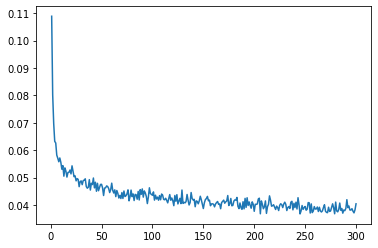

In [99]:

lr, num_epochs, device = 0.001, 300, torch.device('cpu')
epoches, loss_per_epoch = train_seq2seq(download_model, train_iter, lr, num_epochs, tgt_vocab, device, False)
plt.plot(epoches, loss_per_epoch)

In [10]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
num_steps = 8

for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(
        download_model, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ')

go . => nous sois gagné ? pas, 
i lost . => la <bos> la <bos> la <bos> la <bos>, 
he's calm . => la <bos> la <bos> la <bos> la <bos>, 
i'm home . => un j'ai il gagné ? pas, 
